In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [4]:
#!pip uninstall jedi

In [5]:
%config Completer.use_jedi = False

In [7]:
# find out number of images for train and validation
train_cat_image_path = "data/train/cat"
train_dog_image_path = "data/train/dog"
val_cat_image_path = "data/val/cat"
val_dog_image_path = "data/val/dog"

train_cat_image_names = os.listdir(path=train_cat_image_path)
train_dog_image_names = os.listdir(path=train_dog_image_path)
val_cat_image_names = os.listdir(path=val_cat_image_path)
val_dog_image_names = os.listdir(path=val_dog_image_path)
total_train_images = len(train_cat_image_names) + len(train_dog_image_names)
total_val_images = len(val_cat_image_names) + len(val_dog_image_names)

In [8]:
# keeping image hight and weight small, so that I can train model quickly because of system configuration
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
IMAGE_CHANNEL = 3
BATCH_SIZE = 32

TRAIN_STEPS_PER_EPOCHS = int(total_train_images/BATCH_SIZE)
VAL_STEPS_PER_EPOCHS = int(total_val_images/BATCH_SIZE)
print(f"TRAIN_STEPS_PER_EPOCHS: {TRAIN_STEPS_PER_EPOCHS}, VAL_STEPS_PER_EPOCHS: {VAL_STEPS_PER_EPOCHS}")

TRAIN_STEPS_PER_EPOCHS: 781, VAL_STEPS_PER_EPOCHS: 3


In [9]:
# load the base inception model
pre_trained_model = InceptionV3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL), include_top=False)

In [10]:
# I will not train the convoluation layers, so I will freeze them.
# but we can train few layers with our new data if the existing convoluation does not work for our problem
for layer in pre_trained_model.layers:
    layer.trainable = False

In [11]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

From the above model layers, I will take the "mixed2" layer which is (7,7).
I am choosing this layer as output because it has more information and we can then fine tune that with our new data.
Of course, need try different layers to see which exactly gives better output for our problem

In [13]:
# get the "mixed2" layer and its output from the pretrained model as the last layer
ptm_selected_layer = pre_trained_model.get_layer("mixed7")
ptm_selected_layer_output = ptm_selected_layer.output
print(f"base layer shape: {ptm_selected_layer.output_shape}")

base layer shape: (None, 7, 7, 768)


In [14]:
# I am keeping various model hyperparameters small to train it quickly
# I can use Kerastuner to find optimal hyperparameters
def create_model(pre_trained_model, selected_layer):
    # flatten the output from the pretained model layer
    outputs = layers.Flatten()(selected_layer)
    # add fully connected layer, keeping small for quick training, 
    # can use keras tuner to find optimal number of units
    outputs = layers.Dense(units=128, activation=activations.relu)(outputs)
    # add a dropout reguralization layer.  The optimal value of regularization can be found using KerasTuner 
    outputs = layers.Dropout(0.2)(outputs)
    outputs = layers.Dense(units=1, activation=activations.sigmoid)(outputs)
        
    # create base model with inputs and outputs    
    base_model = models.Model(inputs=pre_trained_model.input, outputs=outputs)

    # compile the model
    base_model.compile(optimizer=optimizers.RMSprop(), loss=losses.binary_crossentropy, metrics=["accuracy"])
    return base_model

# Here, I am using ImageDataGenerator to load the images from the directory and peform image augmentation directly since I have less number of images. When we have large number of images, we can use tf.Data and Datacache to avoid memory bottle neck and to improve performance.

In [15]:
# create traing and vlidation generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
# load data from train and validation directory
train_generator = train_datagen.flow_from_directory("data/train",
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="binary")
val_generator = val_datagen.flow_from_directory("data/val",
                                                target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                batch_size=BATCH_SIZE,
                                                class_mode="binary")

Found 25000 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


In [17]:
model = create_model(pre_trained_model, ptm_selected_layer_output)

In [161]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [18]:
#img_path = "data/test/1.jpg"

In [19]:
#from PIL import Image

In [20]:
# img = Image.open(img_path)
# img = img.resize((64, 64))
# img_arry = img_to_array(img)
# print(img_arry.shape)
# img_arry = np.expand_dims(img_arry, axis=0)
# print(img_arry.shape)

In [ ]:
# keeping epochs small to train it quickly
model_history = model.fit(train_generator,
                          steps_per_epoch=TRAIN_STEPS_PER_EPOCHS,
                          epochs=5,
                          validation_data=val_generator,
                          validation_steps=VAL_STEPS_PER_EPOCHS)

In [19]:
history_obj = model_history.history

In [20]:
# get train/validation loss and training/validation accruacy from the history object of the model
train_loss = history_obj["loss"]
train_accuracy = history_obj["accuracy"]
val_loss = history_obj["val_loss"]
val_accuracy = history_obj["val_accuracy"]
epochs = 5

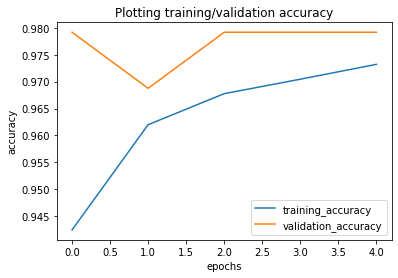

In [21]:
# Plot training and validation accuracy per epoch to see how the train/validation happens
plt.plot(range(epochs), train_accuracy)
plt.plot(range(epochs), val_accuracy)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["training_accuracy", "validation_accuracy"])
plt.title("Plotting training/validation accuracy")
plt.show()

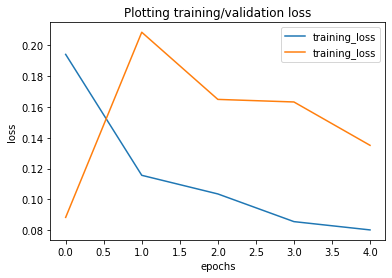

In [22]:
# Plot training and validation loss per epoch to see how the train/validation happens
plt.plot(range(epochs), train_loss)
plt.plot(range(epochs), val_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["training_loss", "training_loss"])
plt.title("Plotting training/validation loss")
plt.show()

# Analysis for the accuracy and loss plots:
From the above, it looks like training accuracy and validation accuracy are increasing with every epoch.
Similarly, training loss and validation loss are decreasing with every epoch.
The accuracy graph shows that training accuracy is still increasing, hence tranining the model for more number of epochs may contribute to increase in accuracy.
Since both training/validation accuracy/loss are moving parallelly, there seems no overfitting and no underfitting as well.

In [23]:
model.save("dog_vs_cat_inception_transfer_learning_v1.h5")

In [24]:
loaded_model = keras.models.load_model("dog_vs_cat_inception_transfer_learning_v1.h5")

In [178]:
org_img = Image.open("data/val/dog/21.jpg")
resized_img = np.resize(org_img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
img_array = img_to_array(resized_img)
img_array /= 255 
img_array = np.expand_dims(img_array, axis=0)
pred_val = loaded_model.predict(img_array, batch_size=1)
category = "cat"
if pred_val[0][0] > 0.6:
    category = "dog"

    

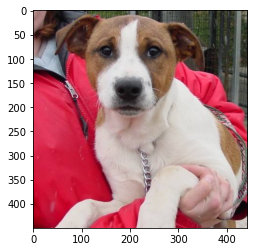

In [179]:
plt.imshow(org_img)

In [180]:
img_array.shape

(1, 150, 150, 3)

In [181]:
res = loaded_model.predict(img_array, batch_size=10)

In [182]:
res

array([[0.53784925]], dtype=float32)

In [183]:
res[0]

array([0.53784925], dtype=float32)

In [155]:
import matplotlib.pyplot as plt

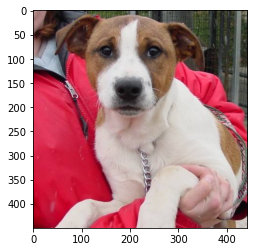

In [118]:
plt.imshow(org_img)

In [201]:
im = org_img.resize((50,50), Image.ANTIALIAS)
# im.save("Thumbnail.png","PNG")
# imgArr = array(im)
# print imgArr.shape

In [202]:
#thumb_nail.shape

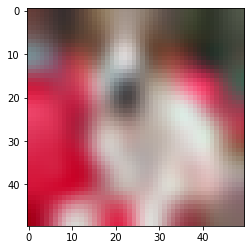

In [203]:
plt.imshow(im)